# Predicting the Outcome of the 2019 Rugby World Cup

On November 2nd, the 2019 Rugby World Cup came to a conclusion in Yokohama, Japan. Twenty teams, six weeks, one champion.

---

Our goal is to build a model that can accurately predict the winner and score for each Rugby World Cup match-up. The overall outline is as follows:

1. Data Collection
2. Data Preprocessing and Visualization
3. Data Mining and Predictions

To evaluate our model, we will be comparing our predictions to the actual results.

In [366]:
import datetime

import psycopg2
import psycopg2.extras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk

## Data Collection

In order to train our model, we shall require a dataset containing historical statistics from previously held rugby matches.

Fortunately, [ESPN Scrum](espnscrum.com) provides data on players, teams, and matches going back to 1896.

### Building ```rugby_pg.db```
* Using a scrapy spider built by peloyeje (found [here](https://github.com/peloyeje/map536-rugby-data-scraper)), it was possible to collect a meaningful sample of matches and results, along with player stats for each match to work with.

* After scraping player, team, and match stats from ESPN Scrum the data was inserted into a SQLite database.
    * Although SQLite format is perfectly fine to work with, we have more experience with PostgreSQL. 
    * To make things easier for ourselves, we converted the SQLite into a PostgreSQL database.
  
### Building ```rankings.csv```
* The World Rugby rankings were gathered from [World Rugby's website](https://www.world.rugby/rankings/mru?lang=en) using Beautiful Soup.

* We were able to gather data points containing ```team_name```, ```abbreviation```, ```num_matches```, ```pts```, ```pos```, ```prev_pts```, ```prev_pos```, ```data```.

    * Each data point represents a single team's data from the given date.

    * World Rugby began recording this data on November 2003, so unfortunately there are many years of competition that are not represented in the data set.
    
* The scraping process was done outside of a Jupyter Notebook, due to the heavy memory consumption required to build this large data set

    * Instead, by creating ```csv_writer.py``` and running this python program on a machine with high-spec hardware, the data set ```rankings.csv``` was built.

In [367]:
'''This is the code from csv_writer.py --- it has been commented out to prevent the Jupyter Notebook from building the data set'''


# import json
# import requests
# from bs4 import BeautifulSoup

# from datetime import timedelta, date

# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# import csv

# def daterange(start_date, end_date):
#     for n in range(int ((end_date - start_date).days)):
#         yield start_date + timedelta(n)

# start_date = date(2003, 10, 13)
# end_date = date(2019, 11, 15)

# csv_data = [['team_name', 'abbreviation', 'num_matches', 'pts', 'pos', 'prev_pts', 'prev_pos', 'date']]

# for single_date in daterange(start_date, end_date):
#     date = single_date.strftime("%Y-%m-%d")

#     ranking_url = "cmsapi.pulselive.com/rugby/rankings/mru?date=%s&client=pulse" % date
#     r  = requests.get("http://" + ranking_url)

#     soup = BeautifulSoup(r.text)

#     data = json.loads(soup.body.p.text)
#     for entry in data['entries']:
#         csv_data.append(
#             [entry['team']['name'], entry['team']['abbreviation'], 
#              entry['matches'], entry['pts'], entry['pos'], entry['previousPts'], 
#              entry['previousPos'], date]
#         )

# with open('rankings.csv', 'w') as csv_file:
#     writer = csv.writer(csv_file)
#     writer.writerows(csv_data)
# csv_file.close()

'This is the code from csv_writer.py --- it has been commented out to prevent the Jupyter Notebook from building the data set'

## Data Visualization -

### Preprocessing ```rankings.csv```

In [368]:
data = pd.read_csv("ranking_data/rankings.csv")

data

,team_name,abbreviation,num_matches,pts,pos,prev_pts,prev_pos,date
0,England,ENG,11,89.948520,1,89.948520,1,2003-10-13
1,New Zealand,NZL,11,89.797710,2,89.797710,2,2003-10-13
2,Australia,AUS,11,84.762690,3,83.805620,4,2003-10-13
3,Ireland,IRE,11,83.924580,4,83.924580,3,2003-10-13
4,France,FRA,11,82.845314,5,82.845314,5,2003-10-13
...,...,...,...,...,...,...,...,...
577110,Monaco,MON,12,23.171558,101,23.171558,101,2019-11-14
577111,Greece,GRE,17,22.546452,102,22.546452,102,2019-11-14
577112,Indonesia,INA,5,21.891422,103,21.891422,103,2019-11-14
577113,Vanuatu,VAN,16,21.453693,104,21.453693,104,2019-11-14


Using the Python library ```matplotlib```, we can create several graphs from the ```rankings.csv``` dataset.

We will mainly explore the dynamics between the top ranking teams.

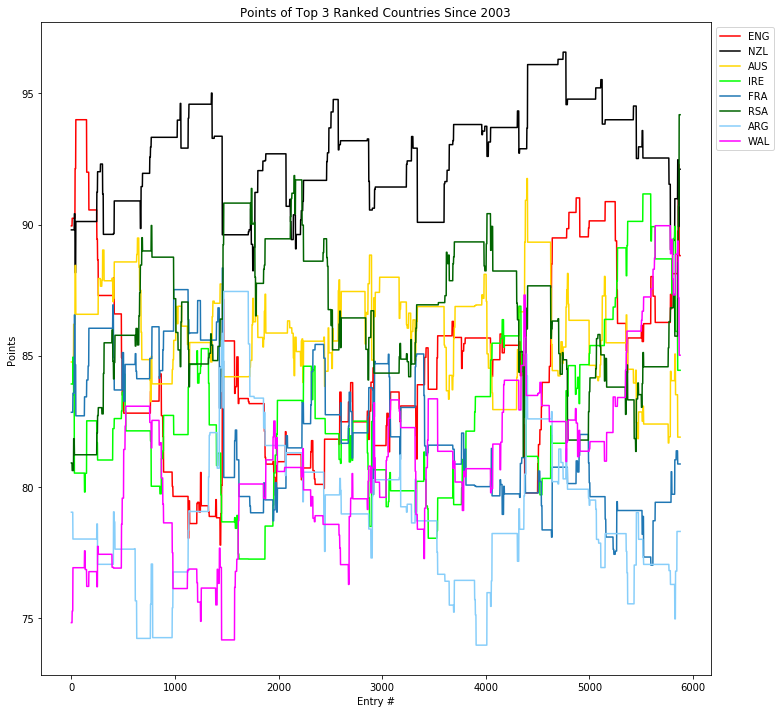

In [369]:
fig = plt.figure(figsize=(12, 12))

for abbr in data.loc[data.pos < 4].abbreviation.unique():
    abbr_pts = data.loc[data.abbreviation == abbr].values[:,[3]]
    if abbr == 'NZL':
        plt.plot(abbr_pts, label = abbr, color = 'black')
    elif abbr == 'ENG':
        plt.plot(abbr_pts, label = abbr, color = 'red')
    elif abbr == 'AUS':
        plt.plot(abbr_pts, label = abbr, color = 'gold')
    elif abbr == 'RSA':
        plt.plot(abbr_pts, label = abbr, color = 'darkgreen')
    elif abbr == 'IRE':
        plt.plot(abbr_pts, label = abbr, color = 'lime')
    elif abbr == 'ARG':
        plt.plot(abbr_pts, label = abbr, color = 'lightskyblue')
    elif abbr == 'WAL':
        plt.plot(abbr_pts, label = abbr, color = 'magenta')
    else:
        plt.plot(abbr_pts, label = abbr)
    
plt.title("Points of Top 3 Ranked Countries Since 2003")
plt.xlabel("Entry #")
plt.ylabel("Points")
ax = plt.gca()
plt.legend(bbox_to_anchor=(1, 1), bbox_transform=ax.transAxes)
plt.show()

Although the graph above presents a ton of valuable information, the data is very noisy and does not allow for easy understanding of the situation that is being represented.

- To improve understanding, we will now calculate the average points per year, rather than the points on each date.

The following table was created directly from ``rankings.csv`` by first inserting the file into a postgres server and then using the SQL command:<br />
~~~~sql
    SELECT team_name, pos, extract(year FROM date) AS year, AVG(points)
    FROM rankings
    GROUP BY team_name, pos, year
    HAVING pos < 4
    ORDER BY year;
~~~~

In [370]:
data = pd.read_csv("ranking_data/avg_pts_perteam_perpos_peryr.csv")

data

,team_name,pos,year,avg
0,Australia,2,2003,88.441790
1,Australia,3,2003,86.103692
2,England,1,2003,92.347882
3,England,2,2003,90.238914
4,France,3,2003,86.553150
...,...,...,...,...
119,South Africa,1,2019,94.185720
120,South Africa,2,2019,90.712790
121,Wales,1,2019,89.432526
122,Wales,2,2019,89.782635


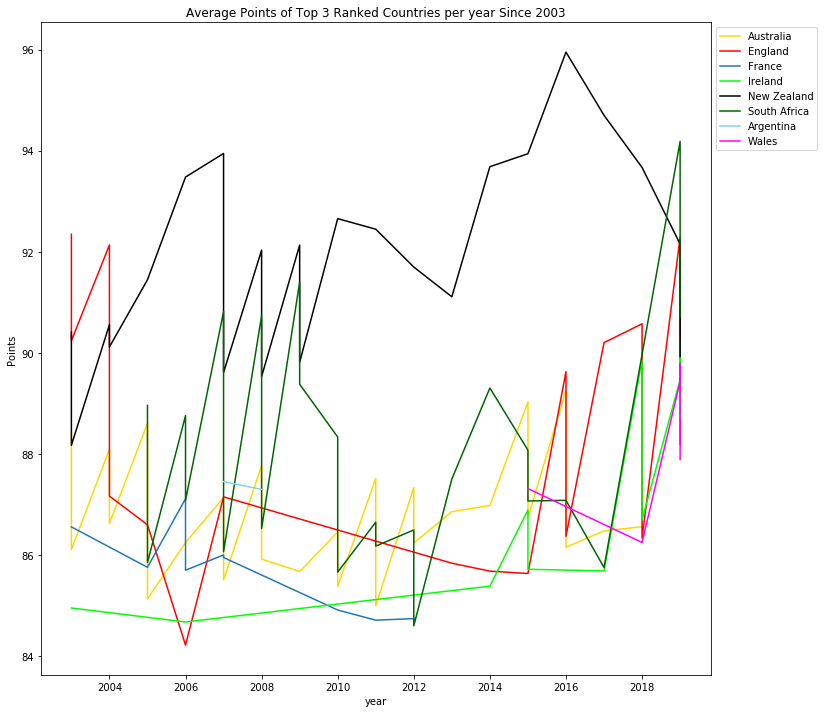

In [371]:
fig = plt.figure(figsize=(12, 12))

for team in data.loc[data.pos < 4].team_name.unique():
    points = data.loc[data.team_name == team].values[:,[3]]
    date = data.loc[data.team_name == team].values[:,[2]]
    if team == 'New Zealand':
        plt.plot(date, points, label = team, color = 'black')
    elif team == 'England':
        plt.plot(date, points, label = team, color = 'red')
    elif team == 'Australia':
        plt.plot(date, points, label = team, color = 'gold')
    elif team == 'South Africa':
        plt.plot(date, points, label = team, color = 'darkgreen')
    elif team == 'Ireland':
        plt.plot(date, points, label = team, color = 'lime')
    elif team == 'Argentina':
        plt.plot(date, points, label = team, color = 'lightskyblue')
    elif team == 'Wales':
        plt.plot(date, points, label = team, color = 'magenta')
    else:
        plt.plot(date, points, label = team)

    
plt.title("Average Points of Top 3 Ranked Countries per year Since 2003")
plt.xlabel("year")
plt.ylabel("Points")
ax = plt.gca()
plt.legend(bbox_to_anchor=(1, 1), bbox_transform=ax.transAxes)
plt.show()

From the graph above, we notice that there are only eight teams that have ever been ranked in the top 3. We verified this by querying the ``rankings.csv`` dataset with:
~~~~sql
SELECT DISTNCT team_name
FROM rankings
WHERE pos < 4;
~~~~

Next, we looked at the average ranking of these eight teams from 2003 to 2019, in order to get a better sense of which teams are consistently ranked at the top. The query follows:
~~~~sql
SELECT team_name, AVG(pos) AS average_position
FROM rankings
GROUP BY team_name
HAVING team_name = 'New Zealand'
OR team_name = 'Australia'
OR team_name = 'England'
OR team_name = 'South Africa'
OR team_name = 'France'
OR team_name = 'Ireland'
OR team_name = 'Argentina'
OR team_name = 'Wales'
ORDER BY average_position;
~~~~

In [372]:
data = pd.read_csv("ranking_data/avg_pos.csv")

data

,team_name,average_position
0,New Zealand,1.119789
1,South Africa,3.254722
2,Australia,3.334354
3,England,4.419772
4,Ireland,5.297771
5,France,5.671941
6,Wales,6.401225
7,Argentina,7.638081


We also looked at the worst ranking of these eight teams during the time period of 2003 to 2019. 

Again, the query follows:
~~~~sql
SELECT team_name, MAX(pos) AS worst_position
FROM rankings
GROUP BY team_name
HAVING team_name = 'New Zealand'
OR team_name = 'Australia'
OR team_name = 'England'
OR team_name = 'South Africa'
OR team_name = 'France'
OR team_name = 'Ireland'
OR team_name = 'Argentina'
OR team_name = 'Wales'
ORDER BY worst_position;
~~~~

In [373]:
data = pd.read_csv("ranking_data/worst_pos.csv")

data

,team_name,worst_position
0,New Zealand,3
1,South Africa,7
2,Australia,7
3,England,8
4,Ireland,9
5,Wales,10
6,France,10
7,Argentina,12


### Preprocessing ```rugby_pg.db```

Using pg_restore on ```rugby_pg.db``` we created a PostgreSQL database containing all the historical data we previously scraped from ESPN Scrum. We interacted with the database by using the Python library, ```pscopg2```.

In [374]:
conn = psycopg2.connect(dbname="rugby", user="postgres", password="postgres")
cur = conn.cursor(cursor_factory = psycopg2.extras.DictCursor)

cur.execute("""
        SELECT *
        FROM
          (SELECT id, date, match_type
           FROM matchs) match_date
        JOIN
          (SELECT *
           FROM matchstats
           JOIN teams ON teams.id = matchstats.team_id) match_team ON match_date.id = match_team.match_id 
        WHERE date > '2003-10-12'::date;
    """)
data = cur.fetchall()

match_data = pd.DataFrame([i.copy() for i in data])

By running further queries on the tables we have gathered from ESPN Scrum, we were able to calculate each team's total win percentage over all games they have previously played. 

The code to obtain this table is given in the code cell below.

In [375]:
cur.execute("""
        SELECT x.name, x.num_matches, y.total_wins, (y.total_wins::NUMERIC / x.num_matches::NUMERIC * 100.0::NUMERIC)::NUMERIC AS win_percentage
        FROM (SELECT teams.name, COUNT(*) AS num_matches
              FROM teams JOIN matchstats ON teams.id = matchstats.team_id
              GROUP BY teams.name) x
              JOIN (SELECT a.name, (a.home_wins + b.away_wins) AS total_wins
                    FROM (SELECT teams.name, COUNT(matchs.won) AS home_wins
                          FROM teams
                          JOIN matchs ON teams.id = matchs.home_team_id
                          GROUP BY teams.name, matchs.won
                          HAVING won = 1) a
                    JOIN (SELECT teams.name, COUNT(matchs.won) AS away_wins
                          FROM teams JOIN matchs ON teams.id = matchs.away_team_id
                          GROUP BY teams.name, matchs.won
                          HAVING won = 2) b
              ON a.name = b.name) y
        ON x.name = y.name
        ORDER BY win_percentage DESC;
    """)
data = cur.fetchall()
win_percentage_data = pd.DataFrame([i.copy() for i in data])
win_percentage_data

,name,num_matches,total_wins,win_percentage
0,Gibraltar,4,4,100.000000000000000000000
1,Qatar,14,12,85.714285714285714286000
2,New Zealand,311,254,81.672025723472668810000
3,Armenia,28,20,71.428571428571428571000
4,Burkina Faso,33,23,69.696969696969696970000
...,...,...,...,...
132,Uzbekistan,22,5,22.727272727272727273000
133,El Salvador,18,4,22.222222222222222222000
134,St Lucia,14,3,21.428571428571428571000
135,Benin,32,6,18.750000000000000000000


However, we notice that there needs to be some cleaning of this dataset as it currently contains teams that have only played a handful of matches. 
- These win percentages can be quite misleading, as some teams have not played a meaningful amount of games.
    - To remove the misleading statistics, we set a new criteria of **having at least 50 games played**.
    - After cleaning the data (using the condition that the minimum number of games played be 50) we obtain the processed table below:

            name  num_matches  total_wins            win_percentage
0    New Zealand          311         254  81.672025723472668810000
1        England          292         188  64.383561643835616438000
2   South Africa          326         202  61.963190184049079755000
3        Georgia          215         133  61.860465116279069767000
4      Australia          324         199  61.419753086419753086000
..           ...          ...         ...                       ...
65         Chile          127          42  33.070866141732283465000
66       Austria          106          34  32.075471698113207547000
67         Italy          275          84  30.545454545454545455000
68       Finland           69          21  30.434782608695652174000
69        Norway           94          28  29.787234042553191489000

[70 rows x 4 columns]


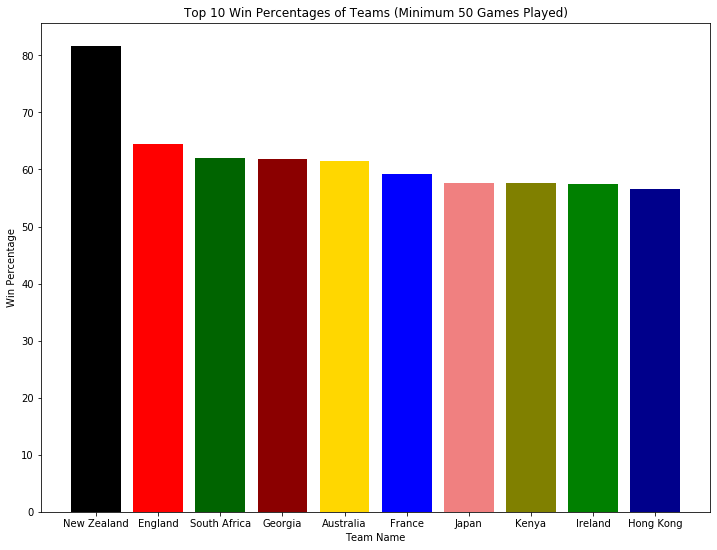

In [376]:
cur.execute("""
        SELECT x.name, x.num_matches, y.total_wins, (y.total_wins::NUMERIC / x.num_matches::NUMERIC * 100.0::NUMERIC)::NUMERIC AS win_percentage
        FROM (SELECT teams.name, COUNT(*) AS num_matches
              FROM teams JOIN matchstats ON teams.id = matchstats.team_id
              GROUP BY teams.name) x
        JOIN (SELECT a.name, (a.home_wins + b.away_wins) AS total_wins
                    FROM (SELECT teams.name, COUNT(matchs.won) AS home_wins
                          FROM teams
                          JOIN matchs ON teams.id = matchs.home_team_id
                          GROUP BY teams.name, matchs.won
                          HAVING won = 1) a
                    JOIN (SELECT teams.name, COUNT(matchs.won) AS away_wins
                          FROM teams JOIN matchs ON teams.id = matchs.away_team_id
                          GROUP BY teams.name, matchs.won
                          HAVING won = 2) b
              ON a.name = b.name) y
        ON x.name = y.name
        WHERE x.num_matches > 49
        ORDER BY win_percentage DESC;
    """)
data = cur.fetchall()

win_percentage_data = pd.DataFrame([i.copy() for i in data])

print(win_percentage_data)

fig = plt.figure(figsize=(12, 9))

win_percentage_data.win_percentage = win_percentage_data.win_percentage.astype(float)
top_win_percentage_data = win_percentage_data.nlargest(10, 'win_percentage')

plt.bar(top_win_percentage_data.name, top_win_percentage_data.win_percentage, color = ['black', 'red', 'darkgreen', 'darkred', 'gold', 'blue', 'lightcoral', 'olive', 'green', 'darkblue'])
plt.title("Top 10 Win Percentages of Teams (Minimum 50 Games Played)")
plt.ylabel("Win Percentage")
plt.xlabel("Team Name")
plt.show()

By querying only the teams with a minimum 50 games played, we have been able to remove many teams with unmeaningful records, but the resulting statistics are still quite misleading. 
- The main issue being, tier 2 teams such as Kenya and Hong Kong do not play against the same caliber opposition when compared to tier 1 teams like New Zealand and England.
    - To remove these misleading statistics, we set a raise our criteria to **having at least 250 games played**.
    - After cleaning the data (using the condition that the minimum number of games played be 250) we obtain the processed table below:

            name  num_matches  total_wins            win_percentage
0    New Zealand          311         254  81.672025723472668810000
1        England          292         188  64.383561643835616438000
2   South Africa          326         202  61.963190184049079755000
3      Australia          324         199  61.419753086419753086000
4         France          314         186  59.235668789808917197000
5          Japan          260         150  57.692307692307692308000
6        Ireland          280         161  57.500000000000000000000
7      Argentina          289         153  52.941176470588235294000
8          Wales          316         163  51.582278481012658228000
9       Scotland          276         120  43.478260869565217391000
10         Italy          275          84  30.545454545454545455000


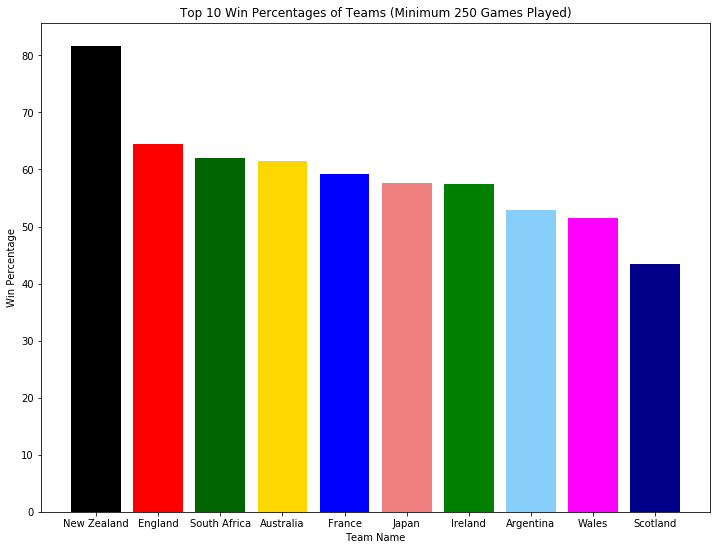

In [377]:
cur.execute("""
        SELECT x.name, x.num_matches, y.total_wins, (y.total_wins::NUMERIC / x.num_matches::NUMERIC * 100.0::NUMERIC)::NUMERIC AS win_percentage
        FROM (SELECT teams.name, COUNT(*) AS num_matches
              FROM teams JOIN matchstats ON teams.id = matchstats.team_id
              GROUP BY teams.name) x
        JOIN (SELECT a.name, (a.home_wins + b.away_wins) AS total_wins
                    FROM (SELECT teams.name, COUNT(matchs.won) AS home_wins
                          FROM teams
                          JOIN matchs ON teams.id = matchs.home_team_id
                          GROUP BY teams.name, matchs.won
                          HAVING won = 1) a
                    JOIN (SELECT teams.name, COUNT(matchs.won) AS away_wins
                          FROM teams JOIN matchs ON teams.id = matchs.away_team_id
                          GROUP BY teams.name, matchs.won
                          HAVING won = 2) b
              ON a.name = b.name) y
        ON x.name = y.name
        WHERE x.num_matches > 249
        ORDER BY win_percentage DESC;
    """)
data = cur.fetchall()

win_percentage_data = pd.DataFrame([i.copy() for i in data])

print(win_percentage_data)

fig = plt.figure(figsize=(12, 9))

win_percentage_data.win_percentage = win_percentage_data.win_percentage.astype(float)
top_win_percentage_data = win_percentage_data.nlargest(10, 'win_percentage')

plt.bar(top_win_percentage_data.name, top_win_percentage_data.win_percentage, color = ['black', 'red', 'darkgreen', 'gold', 'blue', 'lightcoral', 'green', 'lightskyblue', 'magenta', 'darkblue'])
plt.title("Top 10 Win Percentages of Teams (Minimum 250 Games Played)")
plt.ylabel("Win Percentage")
plt.xlabel("Team Name")
plt.show()

The graph above displays teams that regularly compete against one another. This allows for a more meaningful comparison, as we are not looking at teams who likely never face against echother.

### Joining ```rankings.csv``` and ```rugby_pg.db```

By joining the ```rankings.csv``` data with our match statistics, we can observe how rankings correlate to match outcomes.

- Due to World Rugby rankings first being recorded in 2003, our match data for this section will only cover 2003 onwards.

In [378]:
'''This is the code used to gather the ranking position and points for each team on the date of their match --- it has been commented out to prevent the Jupyter Notebook from building the data set'''

# rankings_data = pd.read_csv("ranking_data/rankings.csv")

# match_data.date = match_data.date.astype(str)
# rankings_data.date = rankings_data.date.astype(str)

# ordered_pos = []
# ordered_pts = []

# for rec in match_data.itertuples():
#     team_name = rec.name
#     if team_name == 'United States of America':
#         team_name = 'USA'
#     if rankings_data.loc[(rankings_data.team_name == team_name) & (rankings_data.date == rec.date)].empty:
#         ordered_pos.append(-1)
#         ordered_pts.append(-1)
#     else:
#         ordered_pos.append(
#             rankings_data.loc[
#                 (rankings_data.team_name == team_name) & (rankings_data.date == rec.date)
#             ].values[:,[4]][0][0])

#         ordered_pts.append(
#             rankings_data.loc[
#                 (rankings_data.team_name == team_name) & (rankings_data.date == rec.date)
#             ].values[:,[3]][0][0])

# match_data['pos'] = ordered_pos
# match_data['pts'] = ordered_pts

# export_csv = match_data.to_csv(r'merged.csv', index = None, header=True)

# match_rank_data = pd.read_csv('merged.csv')

# opposition_name = []
# opposition_pos = []
# opposition_pts = []

# for match in match_rank_data.itertuples():
#     opposition_name.append(match_rank_data.loc[
#                 (match_rank_data.match_id == match.match_id) & (match_rank_data.name != match.name)
#             ].values[:,11][0])
    
#     opposition_pos.append(match_rank_data.loc[
#                 (match_rank_data.match_id == match.match_id) & (match_rank_data.name != match.name)
#             ].values[:,12][0])
    
#     opposition_pts.append(match_rank_data.loc[
#                 (match_rank_data.match_id == match.match_id) & (match_rank_data.name != match.name)
#             ].values[:,13][0])

# match_rank_data['opp_name'] = opposition_name
# match_rank_data['opp_pos'] = opposition_pos
# match_rank_data['opp_pts'] = opposition_pts

# export_csv = match_rank_data.to_csv(r'merged_with_oppo.csv', index = None, header=True)

'This is the code used to gather the ranking position and points for each team on the date of their match --- it has been commented out to prevent the Jupyter Notebook from building the data set'

**Note**: If there was no ranking entry for a given team on a certain date, the value ```-1``` was used for ```pos``` and ```pts```.

In [379]:
complete_match_data = pd.read_csv('merged_with_oppo.csv')

complete_match_data

,id,date,match_type,match_id,team_id,scored,conceded,tries,cons,pens,drops,name,pos,pts,opp_name,opp_pos,opp_pts
0,8,2019-11-01,3,298261,8,40,17,6.0,2.0,0.0,0.0,New Zealand,3,89.923170,Wales,4,87.205690
1,1,2019-11-02,3,298262,1,12,32,0.0,0.0,2.0,0.0,England,1,92.289230,South Africa,2,90.712790
2,5,2019-11-02,3,298262,5,32,12,2.0,2.0,2.0,0.0,South Africa,2,90.712790,England,1,92.289230
3,5,2019-10-27,3,298260,5,19,16,1.0,1.0,2.0,0.0,South Africa,4,88.548485,Wales,3,89.369990
4,85,2019-11-02,1,303988,85,38,9,NaN,NaN,NaN,NaN,Austria,88,32.555595,Norway,97,28.744581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8419,16,2003-10-15,3,24561,16,12,36,2.0,1.0,0.0,0.0,Tonga,12,70.075780,Italy,13,69.976906
8420,14,2003-10-15,3,24560,14,19,18,1.0,1.0,2.0,0.0,Fiji,11,72.446686,United States of America,14,68.423140
8421,11,2003-10-15,3,24560,11,18,19,2.0,1.0,2.0,0.0,United States of America,14,68.423140,Fiji,11,72.446686
8422,10,2003-10-14,3,24559,10,67,14,9.0,2.0,1.0,0.0,Argentina,7,79.038790,Namibia,25,58.764744


- Now, we shall observe how often the higher ranked team wins for each fixture. 
    - We expect a positive rate.

In [380]:
data = complete_match_data

high_win = len(data.loc[
        (data.pos < data.opp_pos) 
        & (data.scored > data.conceded)
        & (data.pos != -1) 
        & (data.opp_pos != -1)
    ])
high_total = len(data.loc[
        (data.pos < data.opp_pos)
        & (data.pos != -1) 
        & (data.opp_pos != -1)
    ])

high_win / high_total

0.7376948945276673

Exploring further, how does this rate change when looking at the top $n$ ranked teams?

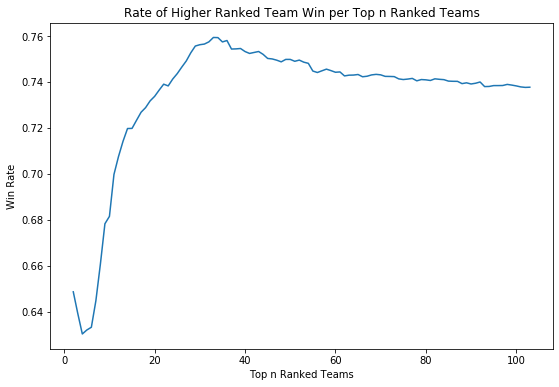

In [381]:
win_rate_by_rank = {}

for n in range(2, 104):
    high_win = len(data.loc[
        (data.pos < data.opp_pos) 
        & (data.scored > data.conceded) 
        & (data.opp_pos < n + 1) 
        & (data.pos != -1) 
        & (data.opp_pos != -1)
    ])
    
    high_total = len(data.loc[
        (data.pos < data.opp_pos) 
        & (data.opp_pos < n + 1)
        & (data.pos != -1) 
        & (data.opp_pos != -1)
    ])
    
    win_rate_by_rank[n] = high_win / high_total
    
fig = plt.figure(figsize=(9, 6))

plt.plot(list(win_rate_by_rank.keys()), list(win_rate_by_rank.values()))
plt.title("Rate of Higher Ranked Team Win per Top n Ranked Teams")
plt.xlabel("Top n Ranked Teams")
plt.ylabel("Win Rate")
# plt.gca().invert_xaxis()
plt.show()

From the graph above, we can observe that games between high ranking teams (teams who rank > 10) are more competitive than those of lesser ranked teams. 

We can also see that as we near the top ranked team, the win rate spikes up. This is likely due to New Zealand's dominance over the years, which can be supported by the overall win rates we looked at earlier.

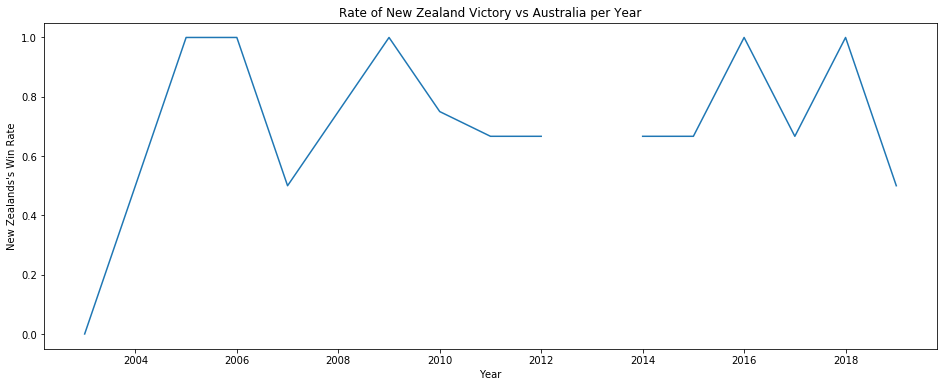

In [382]:
stats = {}

data.date = pd.to_datetime(data['date'])

team_one = 'New Zealand'
team_two = 'Australia'

for n in range(2003, 2020):
    win = len(data.loc[
        (data.name == team_one)
        & (data.opp_name == team_two)
        & (data.scored > data.conceded)
        & (data.date.dt.year == n)
    ])

    total = len(data.loc[
        (data.name == team_one)
        & (data.opp_name == team_two)
        & (data.date.dt.year == n)
    ])

    if total == 0:
        stats[n] = np.nan
    else:
        stats[n] = win / total
    
fig = plt.figure(figsize=(16, 6))

plt.plot(list(stats.keys()), list(stats.values()))
plt.title("Rate of New Zealand Victory vs Australia per Year")
plt.xlabel("Year")
plt.ylabel("New Zealands's Win Rate")
# plt.gca().invert_xaxis()
plt.show()

In a similar fashion, we generalize the data to get the overall win percentage of New Zealand against the top 12 teams in the world. The 12 is chosen due to the fact that the worst position shown in the 'worst_pos.csv' file is 12th:

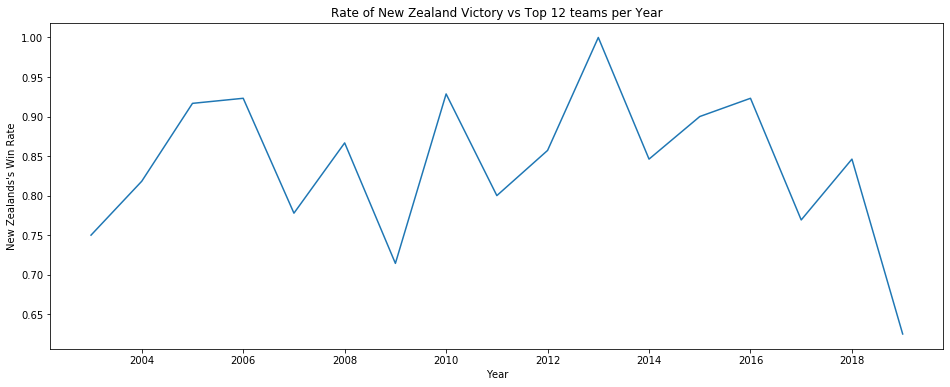

In [383]:
stats = {}

data.date = pd.to_datetime(data['date'])

team_one = 'New Zealand'

for n in range(2003, 2020):
    win = len(data.loc[
        (data.name == team_one)
        & (data.opp_pos < 13)
        & (data.scored > data.conceded)
        & (data.date.dt.year == n)
    ])

    total = len(data.loc[
        (data.name == team_one)
        & (data.opp_pos < 13)
        & (data.date.dt.year == n)
    ])

    if total == 0:
        stats[n] = np.nan
    else:
        stats[n] = win / total
    
fig = plt.figure(figsize=(16, 6))

plt.plot(list(stats.keys()), list(stats.values()))
plt.title("Rate of New Zealand Victory vs Top 12 teams per Year")
plt.xlabel("Year")
plt.ylabel("New Zealands's Win Rate")
plt.show()

Now, we begin to focus more towards team stats on the big stage, the World cup. 

There have been many teams qualifying for the world cup and battling it out in the pool stages, but only a handful of teams have progressed to the knockout stages. 

We have compiled a list of these teams below with their id and the number of knockout stage appearances. 

The data can be found [here](https://www.rugbyworldcup.com/) (Note: the time reference is from 2003 to present time, which is equivalent to 5 World Cups):

   |**Id**|**teams**|**wc knockout appearances**|
   |------|---------|---------------------------|
   |6|Australia|5|
   |9|France|5|
   |8|New Zealand|5|
   |5|South Africa|5|
   |1|England|4|
   |3|Ireland|4|
   |4|Wales|4|
   |10|Argentina|3|
   |2|Scotland|3|
   |14|Fiji|1|
   |23|Japan|1|

## Data Mining and Predictions

Now that we have gathered our data and analyzed several interesting statistics, we can build our model for computation.

First, we will need to query our dataset for each ``match_id`` for the 48 matches that are played at the World Cup.

In [384]:
stats = {}

wc_match_ids = data.loc[
        (data.date > datetime.date(2019, 9, 19))
        & (data.pos < 19)
        & (data.pos != -1)
    ].match_id.unique()

wc_match_ids

/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  


array([298261, 298262, 298260, 298257, 298259, 298256, 298258, 298255,
       298232, 298230, 298229, 298216, 298217, 298218, 298223, 298219,
       298220, 298227, 298221, 298222, 298224, 298231, 298225, 298226,
       298233, 298234, 298235, 298236, 298237, 298238, 298239, 298241,
       298242, 298215, 298243, 298244, 298252, 298245, 298228, 298240,
       298246, 298253, 298254, 298247, 298250])

In [385]:
wc_matches = []

for match_id in wc_match_ids:
    curr_game = data.loc[data.match_id == match_id].iloc[0]
    wc_matches.append(curr_game)
    
# for match in wc_matches:
#     print(match['name'] + " vs. " + match['opp_name'])
    
print(len(wc_matches))

45


- Normally, each Rugby World Cup consists of 48 matches in total. 
    - Unfortunately, in 2019 three of the pool games were called off due to a dangerous typhoon. The result of these matches all were counted as ties. 


- For the rest of our project, we will be ignoring these games, as it is impossible to predict a typhoon from the data we have collected.

In [386]:
wc_match_info = {}
    
for match in wc_matches:
    team_one = match['name']
    team_two = match['opp_name']

    team_one_pos = match['pos']
    team_two_pos = match['opp_pos']
    
    past_match_stats = data.loc[
                (data.name == team_one)
            & (data.opp_name == team_two)
            & (data.date < match['date'])
        ]
    
    score_diff = past_match_stats.sum(axis = 0, skipna = True).scored - past_match_stats.sum(axis = 0, skipna = True).conceded

# Use the actual resulting score difference as Y, to compare our prediction to the actual result
    team_one_score = match['scored']
    team_two_score = match['conceded']
    
    resulting_score_diff = team_one_score - team_two_score
    
    win_count = 0
    draw_count = 0
    loss_count = 0
    
    for past_match in past_match_stats.values:
        if past_match[4] > past_match[5]:
            win_count += 1
        if past_match[4] == past_match[5]:
            draw_count += 1
        if past_match[4] < past_match[5]:
            loss_count += 1

    if (win_count + draw_count + loss_count) > 0:
        win_percentage = win_count / (win_count + draw_count + loss_count)
    else:
        win_percentage = 0.0
    
    wc_match_info[match['match_id']] = [1, score_diff, win_percentage, team_one_pos, team_two_pos, resulting_score_diff]

# wc_match_info contains data for each 2019 World Cup match 
# -- The format is {match_id : [dummy, score_diff, win_percentage, team_one_pos, team_two_pos, resulting_score_diff]}

The above code builds our **testing** dataset. Each testing instance is one of the 2019 World Cup matches, and consists of the following attributes:

    [dummy, score_diff, win_percentage, team_one_pos, team_two_pos, resulting_score_diff]

In [387]:
pre_wc_match_ids = data.loc[
        (data.date < '2019-09-20')
        & (
            (data.name == 'Argentina')
            | (data.name == 'Australia')
            | (data.name == 'Canada')
            | (data.name == 'England')
            | (data.name == 'Fiji')
            | (data.name == 'France')
            | (data.name == 'Georgia')
            | (data.name == 'Ireland')
            | (data.name == 'Italy')
            | (data.name == 'Japan')
            | (data.name == 'Namibia')
            | (data.name == 'New Zealand')
            | (data.name == 'Russia')
            | (data.name == 'Samoa')
            | (data.name == 'Scotland')
            | (data.name == 'South Africa')
            | (data.name == 'Tonga')
            | (data.name == 'Uruguay')
            | (data.name == 'USA')
            | (data.name == 'Wales')
        )
    ].match_id.unique()
    
pre_wc_matches = []

for match_id in pre_wc_match_ids:
    curr_game = data.loc[data.match_id == match_id].iloc[0]
    pre_wc_matches.append(curr_game)
    
pre_wc_match_info = {}

The above code builds our **training** dataset. Each testing instance is one of the many matches played by a World Cup team prior to the 2019 World Cup, and consists of the following attributes:

    [dummy, score_diff, win_percentage, team_one_pos, team_two_pos, resulting_score_diff]

In [388]:
wc_teams = [
    'Argentina',
    'Australia',
    'Canada',
    'England',
    'Fiji',
    'France',
    'Georgia',
    'Ireland',
    'Italy',
    'Japan',
    'Namibia',
    'New Zealand',
    'Russia',
    'Samoa',
    'Scotland',
    'South Africa',
    'Tonga',
    'Uruguay',
    'USA',
    'Wales'
]

for match in pre_wc_matches:
    team_one = match['name']
    team_two = match['opp_name']
    
    if (team_one not in wc_teams) or (team_two not in wc_teams):
        continue

    team_one_pos = match['pos']
    team_two_pos = match['opp_pos']
    
    past_match_stats = data.loc[
                (data.name == team_one)
            & (data.opp_name == team_two)
            & (data.date < match['date'])
            & (data.date > datetime.date(2003, 1, 1))
        ]
    score_diff = past_match_stats.sum(axis = 0, skipna = True).scored - past_match_stats.sum(axis = 0, skipna = True).conceded
    
# Use the actual resulting score difference as Y, to compare our prediction to the actual result
    team_one_score = match['scored']
    team_two_score = match['conceded']
    
    resulting_score_diff = team_one_score - team_two_score
    
    win_count = 0
    draw_count = 0
    loss_count = 0
    
    for past_match in past_match_stats.values:
        if past_match[4] > past_match[5]:
            win_count += 1
        if past_match[4] == past_match[5]:
            draw_count += 1
        if past_match[4] < past_match[5]:
            loss_count += 1

    if (win_count + draw_count + loss_count) > 0:
        win_percentage = win_count / (win_count + draw_count + loss_count)
    else:
        win_percentage = 0.0
    
    pre_wc_match_info[match['match_id']] = [1, score_diff, win_percentage, team_one_pos, team_two_pos, resulting_score_diff]
    
#     print(match['name'] + " vs. " + match['opp_name'])
#     print(pre_wc_match_info[match['match_id']])
    
# pre_wc_match_info contains data for all matches prior to the 2019 World Cup
# -- The format is {match_id : [dummy, score_diff, win_percentage, team_one_pos, team_two_pos, resulting_score_diff]}

/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.


We will now cast our dataset into numpy as an array. This allows for easy use of the many algorithms provided by ``sklearn``.

In [389]:
training_data = np.asarray(list(pre_wc_match_info.values()), dtype=np.float32)
print(training_data.shape)

testing_data = np.asarray(list(wc_match_info.values()), dtype=np.float32)
print(testing_data.shape)

(1180, 6)
(45, 6)


### Linear Regression Predictions

As we would like to predict not just the victor of each match, but the resulting score too, linear regression is and incredibly useful tool.

Using ``sklearn`` for computation, the outcome of our linear regression predictions can be see below.

In [390]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

train_X = training_data[:,0:-1]  # [dummy, score_diff, win_percentage, team_one_pos, team_two_pos]
# train_X = training_data[:,[1]]  # [score_diff]
train_Y = training_data[:,-1:]   # [resulting_score_diff]

test_X = testing_data[:,0:-1]    # [dummy, score_diff, win_percentage, team_one_pos, team_two_pos]
# test_X = testing_data[:,[1]]    # [score_diff]
test_Y = testing_data[:,-1:]     # [resulting_score_diff]

regr = sk.linear_model.LinearRegression()
regr.fit(train_X, train_Y)

pred_Y = regr.predict(test_X)

In [391]:
binary_pred = []
binary_actual = []
correct_count = 0

for val in pred_Y:
    if val > 0:
        binary_pred.append(1)
    else:
        binary_pred.append(0)
        
accuracy_rating = ""

for indx, val in enumerate(binary_pred, 0):
    correct_outcome_check = (np.sign(pred_Y[indx]) == np.sign(test_Y[indx]))
    
    if (abs(pred_Y[indx] - test_Y[indx]) == 0):
        accuracy_rating = "Spot On!"
    elif (abs(pred_Y[indx] - test_Y[indx]) < 5) and (np.sign(pred_Y[indx]) == np.sign(test_Y[indx])):
        accuracy_rating = "Good"
    elif (abs(pred_Y[indx] - test_Y[indx]) < 20) and (np.sign(pred_Y[indx]) == np.sign(test_Y[indx])):
        accuracy_rating = "Close"
    elif (np.sign(pred_Y[indx]) == np.sign(test_Y[indx])):
        accuracy_rating = "Correct, but score need improvement"
    elif (np.sign(pred_Y[indx]) != np.sign(test_Y[indx])):
        accuracy_rating = "Wrong"

    print(wc_matches[indx]['name'] + " vs. " + wc_matches[indx]['opp_name'] + ":       Predicted: " + str(pred_Y[indx]) + "  |  Actual: "+ str(test_Y[indx]) + "    " + accuracy_rating)
    if correct_outcome_check:
        correct_count += 1
        
correct_count / len(binary_pred)

New Zealand vs. Wales:       Predicted: [7.090617]  |  Actual: [23.]    Close
England vs. South Africa:       Predicted: [6.984626]  |  Actual: [-20.]    Wrong
South Africa vs. Wales:       Predicted: [1.6681337]  |  Actual: [3.]    Good
France vs. Wales:       Predicted: [-11.87104]  |  Actual: [-1.]    Close
England vs. New Zealand:       Predicted: [1.6039114]  |  Actual: [12.]    Close
Ireland vs. New Zealand:       Predicted: [-3.8989372]  |  Actual: [-32.]    Correct, but score need improvement
Japan vs. South Africa:       Predicted: [-1.6521168]  |  Actual: [-23.]    Correct, but score need improvement
Australia vs. England:       Predicted: [-3.685381]  |  Actual: [-24.]    Correct, but score need improvement
Samoa vs. Scotland:       Predicted: [-11.700047]  |  Actual: [-34.]    Correct, but score need improvement
Georgia vs. Uruguay:       Predicted: [23.015724]  |  Actual: [26.]    Good
Namibia vs. South Africa:       Predicted: [-45.6161]  |  Actual: [-54.]    Close
Austra

0.9111111111111111

These predictions have a high accuracy rate of 91.11%. Additionally, the predicted scores are mostly within 20 points of the actual result.

## Decision Tree Induction Predictions

We'll next use the decision tree induction algorithm. We will again train the classifier with data up until the 2019 world cup and classify the teams by the furthest stage they have reached. The classifications will be group stage, quarter finals, semi finals, and finals. 

In [392]:
previous_wc_matches = data.loc[
        #((data.date >= '2019-09-20') & (data.date <= '2019-11-02')
        ((data.date >= '2015-09-18') & (data.date <= '2015-10-31')
        |(data.date >= '2011-09-09') & (data.date <= '2011-10-23')
        |(data.date >= '2007-09-07') & (data.date <= '2007-10-20')
        |(data.date >= '2003-10-10') & (data.date <= '2003-11-22')
        )
        
        & (
            (data.name == 'Argentina')
            | (data.name == 'Australia')
            | (data.name == 'Canada')
            | (data.name == 'England')
            | (data.name == 'Fiji')
            | (data.name == 'France')
            | (data.name == 'Georgia')
            | (data.name == 'Ireland')
            | (data.name == 'Italy')
            | (data.name == 'Japan')
            | (data.name == 'Namibia')
            | (data.name == 'New Zealand')
            | (data.name == 'Russia')
            | (data.name == 'Samoa')
            | (data.name == 'Scotland')
            | (data.name == 'South Africa')
            | (data.name == 'Tonga')
            | (data.name == 'Uruguay')
            | (data.name == 'USA')
            | (data.name == 'Wales')
        )
    ]

In [393]:
# We obtain the worst seeded teams that have ever qualified for the world cup
previous_wc_matches.pos.sort_values(axis=0, ascending=False)

8423    25
8376    25
3411    25
8407    25
7977    24
        ..
8369     1
6747     1
7937     1
2521     1
8381     1
Name: pos, Length: 333, dtype: int64

In [394]:
# function extends the decision tree by creating a new
# node. A node in the decision tree has either a test condition, denoted as
# node.test-cond, or a class label, denoted as node.label
def createNode():
    return None

# The f ind-best-split0 function determines which attribute should be
# selected as the test condition for splitting the training records. As previously
# noted, the choice of test condition depends on which impurity
# measure is used to determine the goodness of a split. Some widely used
# measures include entropy, the Gini index, and the 12 statistic.
def find_best_split():
    return None

# The Cl-assifyQ function determines the class label to be assigned to a
# leaf node. For each leaf node t,let p(ilt) denote the fraction of training
# records from class i associatedw ith the node f. In most cases?th e leaf
# node is assigned to the class that has the majority number of training
# records:
#            leaf .label: argmax p(i,lt), (4.8)
# where the argmax operator returns the argument i that maximizes the
# expression p(i,lt). Besides providing the information needed to determine
# the class label of a leaf node, the fraction p(i,lt) can also be used to estimate
# the probability that a record assigned to the leaf node t belongs
# to class z. Sections 5.7.2 and 5.7.3 describe how such probability esti
# mates can be used to determine the oerformance of a decision tree under
# different cost functions.
def Classify():
    return None

# The stopping-cond() function is used to terminate the tree-growing process
# by testing whether all the records have either the same class label
# or the same attribute values. Another way to terminate the recursive
# function is to test whether the number of records have fallen below some
# minimum threshold.
def stopping_cond(data, att):
    return None

def convert(data):
    converted_data = data[['name', 'pos', 'pts', 'scored', 'conceded']]
    converted_data['furthest_stage'] = ["" for i in range(333)]
    #converted_data.insert(0, "furthest_stage", True)
    #print(converted_data)
    return converted_data

def TreeGrowth(data, att):
    if stopping_cond(data, att) == True:
        leaf = createNode()
        leaf.label = Classify(data)
        return leaf
    
#    else:
#        root = createNode()
#        root.test_cond = find_best_split(data, att)
#        V = {v|v is a possible outcome of root.test_cond}
        
#        for v in V:
#            E_v = {e|root.test_cond(e) = v and e is in E}
#            add child as descendent of root and label the edge (root->child) as v
    
#    return root


train_data = convert(previous_wc_matches)

attributes = ['name', 'pos', 'pts', 'scored', 'conceded', 'furthest_stage'] # [name, pos, pts, scored, conceded, furthest_stage]
TreeGrowth(train_data, attributes)

train_data




/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,name,pos,pts,scored,conceded,furthest_stage
698,England,8,79.771940,60,3,
701,Uruguay,19,62.108723,3,60,
704,Wales,2,87.311480,23,13,
705,Fiji,10,76.963264,13,23,
741,Wales,5,84.630570,54,9,
...,...,...,...,...,...,...
8418,Italy,13,69.976906,36,12,
8419,Tonga,12,70.075780,12,36,
8420,Fiji,11,72.446686,19,18,
8422,Argentina,7,79.038790,67,14,
